In [1]:
# !pip install ktrain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.3 MB 1.2 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 981 kB 50.1 MB/s 
     |████████████████████████████████| 263 kB 71.8 MB/s 
     |████████████████████████████████| 2.8 MB 62.3 MB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 468 kB 67.7 MB/s 
     |████████████████████████████████| 596 kB 53.7 MB/s 
     |████████████████████████████████| 86 kB 6.1 MB/s 
     |████████████████████████████████| 3.3 MB 48.3 MB/s 
     |████████████████████████████████| 880 kB 72.2 MB/s 
  Created wheel for ktrain: filename=ktrain-0.31.2-py3-none-any.whl size=25313063 sha256=f1855350c42ad35a447a622a897afcce3ffc1ca74765bc347baecc82cb2a17aa
  Stored in directory: /root/.cache/pip/wheels/0a/b3/dd/512a01ea0b4f31d96163518b58361bb72d3bcb916d291052e7
  Cr

In [2]:
# !pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
import ktrain
from joblib import dump, load

In [2]:
pd.set_option('display.max_colwidth', 500)

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
df_positive_news = pd.read_csv('df_positive_news_yelp.csv')
df_negative_news = pd.read_csv('df_negative_news_yelp.csv')

In [22]:
df_positive_news.shape, df_negative_news.shape

((60533, 7), (104827, 7))

In [23]:
# !pip install pyLDAvis

In [24]:
import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import time 

import pyLDAvis
from pyLDAvis import gensim_models as gensimvis
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore")

In [25]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list_positive = df_positive_news['clean_text'].tolist()        
data_tokens_positive = list(sent_to_words(data_list_positive))

data_list_negative = df_negative_news['clean_text'].tolist()        
data_tokens_negative = list(sent_to_words(data_list_negative))

In [27]:
%time

bigram_positive = gensim.models.Phrases(data_tokens_positive, min_count=1, threshold=1) 
trigram_positive = gensim.models.Phrases(bigram_positive[data_tokens_positive], threshold=1)

bigram_mod_positive = gensim.models.phrases.Phraser(bigram_positive)
trigram_mod_positive = gensim.models.phrases.Phraser(trigram_positive)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [28]:
%time

bigram_negative = gensim.models.Phrases(data_tokens_negative, min_count=1, threshold=1) 
trigram_negative = gensim.models.Phrases(bigram_negative[data_tokens_negative], threshold=1)

bigram_mod_negative = gensim.models.phrases.Phraser(bigram_negative)
trigram_mod_negative = gensim.models.phrases.Phraser(trigram_negative)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [29]:
import nltk
from nltk.corpus import stopwords
import spacy
nltk.download('stopwords')
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts, bigram_mod):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts, bigram_mod, trigram_mod):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /home/vritti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
%%time

# Remove Stop Words
data_tokens_nostops_positive = remove_stopwords(data_tokens_positive)

# Create n-grams
data_words_bigrams_positive = make_bigrams(data_tokens_nostops_positive, bigram_mod_positive)
data_words_trigrams_positive = make_trigrams(data_tokens_nostops_positive, bigram_mod_positive, trigram_mod_positive)

# Combine tokens and n-grams
data_tokens_combined_positive = data_words_trigrams_positive

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized_positive = lemmatization(data_tokens_combined_positive, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized_positive[:1])

['lie', 'employs_new_informant_help', 'solve_tricky_drug_trafficke', 'case_atwater_struggles_reconcile', 'personal_professional_life_reache', 'decision']
CPU times: user 15min 24s, sys: 2.12 s, total: 15min 26s
Wall time: 15min 27s


In [31]:
%%time

# Remove Stop Words
data_tokens_nostops_negative = remove_stopwords(data_tokens_negative)

# Create n-grams
data_words_bigrams_negative = make_bigrams(data_tokens_nostops_negative, bigram_mod_negative)
data_words_trigrams_negative = make_trigrams(data_tokens_nostops_negative, bigram_mod_negative, trigram_mod_negative)

# Combine tokens and n-grams
data_tokens_combined_negative = data_words_trigrams_negative

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized_negative = lemmatization(data_tokens_combined_negative, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized_negative[:1])

['school_leaders_canceled_classe', 'day_failing_reach_agreement', 'teachers_union_covid_safety', 'school_district', 'chicago_teachers_union_sought', 'revert_remote_instruction_latest', 'surge_infections_sides_hammer', 'deal_chicago_public', 'remote_learning_work', 'schools_safely_remain_open', 'protocols_place', 'move_cancel', 'classes_activitie', 'thursday_affect', 'choice_cancel_classes_tomorrow', 'conference', 'students_returned_class_monday', 'covid_infections_fueled_omicron', 'variant_record_levels_school', 'districts_nationwide_grappled_issue', 'virus_testing_tweaking_protocol', 'adjustments_response_shifting_pandemic', 'said_wednesday_country_better', 'safely_open_include', 'chicago_former_president', 'donald_trump_called_closure', 'devastating_chicago_teacher', 'said_teachers_want', 'return_person_instruction_current', 'surge_subside', 'saying_though_right_middle', 'major_surge_breaking_records', 'officials_teacher', 'action_approved_members_calle', 'remote_instruction_cases_su

In [33]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_positive = corpora.Dictionary(data_lemmatized_positive)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_positive = [dictionary_positive.doc2bow(doc) for doc in data_lemmatized_positive]

In [34]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary_negative = corpora.Dictionary(data_lemmatized_negative)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_negative = [dictionary_negative.doc2bow(doc) for doc in data_lemmatized_negative]

In [35]:
# tuning
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [37]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

workers = num_processors-1

Available CPUs: 6


In [51]:
# Running LDA with 9 topics

%time

positive_lda_model = LdaMulticore(corpus=doc_term_matrix_positive,
                       id2word=dictionary_positive,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=positive_lda_model, texts=data_lemmatized_positive, \
                                     dictionary=dictionary_positive, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs

Coherence Score:  0.3842890511377687


In [52]:
%time

lda_display = gensimvis.prepare(positive_lda_model, doc_term_matrix_positive, dictionary_positive, \
                                sort_topics=False, mds='mmds')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/

In [53]:
pyLDAvis.display(lda_display)

In [54]:
from pprint import pprint
pprint(positive_lda_model.print_topics())

[(0,
  '0.006*"say" + 0.006*"team" + 0.005*"go" + 0.005*"also" + 0.005*"time" + '
  '0.005*"make" + 0.004*"get" + 0.004*"game" + 0.004*"year" + 0.004*"season"'),
 (1,
  '0.005*"also" + 0.004*"say" + 0.004*"city" + 0.004*"year" + 0.004*"include" '
  '+ 0.004*"good" + 0.004*"make" + 0.003*"home" + 0.003*"time" + 0.003*"cub"'),
 (2,
  '0.009*"roof" + 0.006*"also" + 0.004*"roofing" + 0.003*"work" + 0.003*"well" '
  '+ 0.003*"time" + 0.002*"door" + 0.002*"roof_covere" + 0.002*"repair" + '
  '0.002*"need"'),
 (3,
  '0.007*"also" + 0.006*"fact" + 0.004*"well" + 0.004*"section" + '
  '0.003*"roof_covere" + 0.003*"work" + 0.003*"get" + '
  '0.003*"family_lawyers_near" + 0.002*"roof" + 0.002*"known_fact"'),
 (4,
  '0.006*"lawyer" + 0.005*"also" + 0.005*"may" + 0.004*"company" + '
  '0.004*"need" + 0.004*"get" + 0.004*"case" + 0.004*"work" + 0.003*"well" + '
  '0.003*"attorney"'),
 (5,
  '0.005*"also" + 0.004*"source_hotel_food_drink" + 0.003*"pizza" + '
  '0.003*"fact" + 0.002*"chicago_style_thi

In [55]:
# Running LDA with 9 topics

%time

negative_lda_model = LdaMulticore(corpus=doc_term_matrix_negative,
                       id2word=dictionary_negative,
                       num_topics=7,
                       random_state=100,
                       passes=10,
                       alpha="asymmetric",
                       eta="auto",
                       workers = workers)

coherence_model_lda = CoherenceModel(model=negative_lda_model, texts=data_lemmatized_negative, \
                                     dictionary=dictionary_negative, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs

Coherence Score:  0.442814743304246


In [56]:
%time

lda_display = gensimvis.prepare(negative_lda_model, doc_term_matrix_negative, dictionary_negative, \
                                sort_topics=False, mds='mmds')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/software-msca/ivy2/env/2021.05/ML2/lib/

In [57]:
pyLDAvis.display(lda_display)

In [58]:
pprint(negative_lda_model.print_topics())

[(0,
  '0.021*"say" + 0.005*"go" + 0.004*"time" + 0.004*"year" + 0.004*"also" + '
  '0.004*"make" + 0.004*"get" + 0.004*"state" + 0.004*"see" + 0.003*"come"'),
 (1,
  '0.006*"product" + 0.005*"owns_shares_industrial_product" + '
  '0.005*"industrial_products_company_stock" + '
  '0.005*"shares_illinois_tool_work" + 0.003*"total_transaction" + '
  '0.003*"additional_shares_last_quarter" + 0.003*"illinois_tool_work" + '
  '0.003*"welding_construction_products_specialty" + 0.002*"equipment" + '
  '0.002*"represents_dividend_annualized_basis"'),
 (2,
  '0.011*"bull" + 0.005*"game" + 0.004*"say" + 0.003*"buck" + '
  '0.003*"chicago_bull" + 0.003*"team" + 0.002*"state" + 0.002*"season" + '
  '0.002*"also" + 0.002*"point"'),
 (3,
  '0.003*"say" + 0.001*"area" + 0.001*"day" + 0.001*"school" + '
  '0.001*"physical_facilities_installed_maintaine" + '
  '0.001*"illinois_american_water" + 0.001*"time" + 0.001*"year" + '
  '0.001*"issue" + 0.001*"surfaces_cleanable_properly_designe"'),
 (4,
  '0.00

### Sentiment Change Over Time

In [60]:
df_news_sentiment = pd.read_csv('df_news_sentiment_yelp.csv')

In [61]:
df_news_sentiment.shape

(165360, 5)

In [62]:
df_news_sentiment.head()

,Unnamed: 0,Text,Sentiment,Prob_Neg,Prob_Pos
0,0,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,Negative,1.000000,7.388560e-12
1,1,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,Positive,0.065997,9.340032e-01
2,2,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,Negative,1.000000,1.628016e-11
3,3,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,Positive,0.000521,9.994790e-01
4,4,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residence fireplace killed following ultimate visitation funeral companies start probably adopted procession oak woods cemetery 67th road the yea...,Positive,0.000292,9.997077e-01


In [64]:
df_news_sentiment.drop(columns=['Unnamed: 0'], inplace=True)

In [66]:
df_news = pd.read_csv('df_cleaned_news.csv')

In [67]:
df_news.dropna(inplace=True)

In [68]:
df_news.drop(columns=['Unnamed: 0'], inplace=True)

In [69]:
df_news.reset_index(inplace=True, drop=True)

In [71]:
df_news_sentiment_yelp = df_news.join(df_news_sentiment, how='inner')

In [72]:
df_news_sentiment_yelp.head()

,date,clean_text,clean_title,Text,Sentiment,Prob_Neg,Prob_Pos
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,Negative,1.000000,7.388560e-12
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,Positive,0.065997,9.340032e-01
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,Negative,1.000000,1.628016e-11
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,Positive,0.000521,9.994790e-01
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighter amongst critically injured belmont central residenc

In [73]:
df_news_sentiment_yelp.dtypes

date            object
clean_text      object
clean_title     object
Text            object
Sentiment       object
Prob_Neg       float64
Prob_Pos       float64
dtype: object

In [75]:
from datetime import datetime

In [80]:
# datetime_object = datetime.strptime('2022-01-06', '%Y-%m-%d')
df_news_sentiment_yelp['date_new'] = df_news_sentiment_yelp['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df_news_sentiment_yelp.head()

,date,clean_text,clean_title,Text,Sentiment,Prob_Neg,Prob_Pos,date_new
0,2022-01-06,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,no deal school chicago cancels classes 2nd day,chicago ap chicago school leaders canceled classes thursday second consecutive day failing reach agreement teachers union covid safety protocols nation third largest school district the chicago teachers union sought revert remote instruction latest surge infections sides hammer deal but chicago public schools leaders said remote learning work schools safely remain open protocols place the move cancel classes activities thursday affects roughly students ...,Negative,1.000000,7.388560e-12,2022-01-06
1,2022-01-06,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,watch chicago p d preview wednesday,chicago pd lies season episode promo voight employs new informant help solve tricky drug trafficking case atwater struggles reconcile personal professional life reaches decision jesseleesoffer marinasqu trspiridakos nbcchicagopd,Positive,0.065997,9.340032e-01,2022-01-06
2,2022-01-06,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,trump solution chicago public schools king solomon blog,wise foolish the chicago tribune article titled chicago public schools cancels classes thursday deadlock union continues trump biden press secretary comment impasse reported trumps solution follows educate children person give every dollar spent education directly students get failing government schools trump said statement the purpose this post is relate ancient wisdom proverb trump solution king solomon go presence foolish man thou perceivest lips...,Negative,1.000000,1.628016e-11,2022-01-06
3,2022-01-06,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,family friends colleagues gathering today south side church attend funeral services chicago firefighter mashawn plummer,the neighbors near mashawn plummer portage park firehouse knew often sat outside friendly presence station he showed early shifts ready job thrilled friends family recalled chicago firefighter emt mashawn plummer engine chicago fire department hundreds chicago firefighters joined family friends thursday lay plummer rest died december battling apartment fire northwest side they remembered plummer gentle giant followed dream becoming chicago fi...,Positive,0.000521,9.994790e-01,2022-01-06
4,2022-01-06,mashawn plummer died final month preventing fireplace town northwest aspect additionally killed civilian a visitation held plummer wednesday night time a remaining visitation probably held home hope church e 114th st related chicago firefighte

In [101]:
sentiment_time = df_news_sentiment_yelp.pivot_table(index="date_new", columns="Sentiment", aggfunc = "count", values="Text").\
reset_index()
sentiment_time["Total"] = sentiment_time["Negative"]+sentiment_time["Positive"]
sentiment_time["Neg_Perc"] = sentiment_time["Negative"]/sentiment_time["Total"]
sentiment_time["Pos_Perc"] = sentiment_time["Positive"]/sentiment_time["Total"]

sentiment_time.head()

Sentiment,date_new,Negative,Positive,Total,Neg_Perc,Pos_Perc
0,2022-01-01,537,287,824,0.651699,0.348301
1,2022-01-02,527,320,847,0.622196,0.377804
2,2022-01-03,693,369,1062,0.652542,0.347458
3,2022-01-04,960,346,1306,0.735069,0.264931
4,2022-01-05,1351,487,1838,0.735038,0.264962


<AxesSubplot:title={'center':'Count of Positive Sentiment over time'}, xlabel='date_new'>

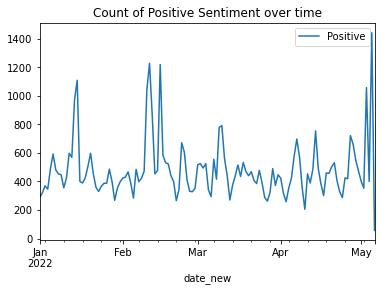

In [109]:
sentiment_time.plot('date_new' , 'Positive', title = "Count of Positive Sentiment over time")

<AxesSubplot:title={'center':'Count of Negative Sentiment over time'}, xlabel='date_new'>

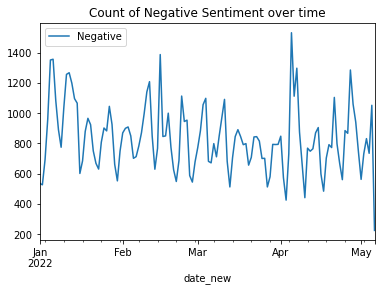

In [110]:
sentiment_time.plot('date_new' , 'Negative', title = "Count of Negative Sentiment over time")

<AxesSubplot:title={'center':'Percentage of Positive Sentiment over time'}, xlabel='date_new'>

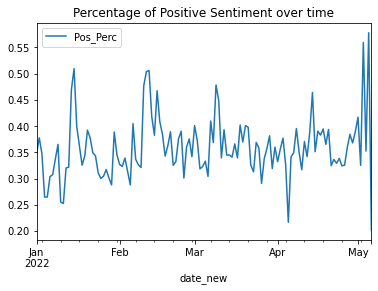

In [108]:
sentiment_time.plot('date_new' , 'Pos_Perc', title = "Percentage of Positive Sentiment over time")

<AxesSubplot:title={'center':'Percentage of Negative Sentiment over time'}, xlabel='date_new'>

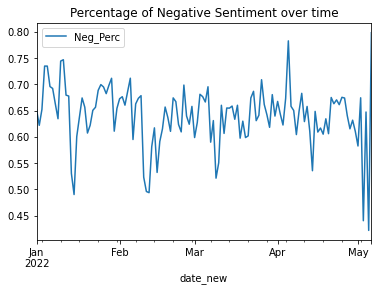

In [111]:
sentiment_time.plot('date_new' , 'Neg_Perc', title = "Percentage of Negative Sentiment over time")